In [1]:
!tar -xzf /kaggle/input/task-s/binding_affinity_data.tar.xz
!pip install pylcs blosum torcheval --quiet

In [2]:
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import pylcs
DEVICE = 'cuda'

In [3]:
df = pd.read_csv('/kaggle/working/binding_affinity_data.csv')
df = df[df['MHC_sequence'].apply(len) > 300]
df.reset_index(inplace=True)

seqs = df['MHC_sequence'].unique().tolist()
mhc_type_to_seq = {df['MHC_type'][i]: df['MHC_sequence'][i] for i in range(len(df))}
mhc_types = [t for t, seq in mhc_type_to_seq.items()]
mhc_type_to_idx = {t: i for i, t in enumerate(mhc_types)}

In [4]:
# Peptide tokenization

amino_acids = list(sorted(set(''.join(df['peptide_sequence'].tolist())))) + ['-', '*']
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
START_TOKEN = aa_to_idx['*']
PEPTIDE_LEN = 15
def encode_peptide(peptide_str):
    return [START_TOKEN] + [aa_to_idx[peptide_str[i]] if i < len(peptide_str) else aa_to_idx['-']  for i in range(PEPTIDE_LEN - 1)]

In [5]:
# MHC tokenization and calculation of entropy for each position

from collections import Counter

entropies = []
for i in range(max([len(x) for x in seqs])):
    amino_counter = Counter()
    e = 0
    all_cnt = 0
    for seq in seqs:
        if i >= len(seq) or len(seq) < 300:
            continue
        amino_counter.update(seq[i])
        all_cnt += 1
    for x, cnt in amino_counter.items():
        e += -cnt / all_cnt * np.log2(cnt / all_cnt)
    entropies.append(e)
    
def encode_mhc(mhc_str):
    return [START_TOKEN] + [aa_to_idx[mhc_str[i]] if i < len(mhc_str) else aa_to_idx['-'] for i in mask_ind[0]]

ENTROPY_THRESHOLD = 0.8
mask = (np.array(entropies) > ENTROPY_THRESHOLD)
mask_ind = np.where(mask)
MHC_SEQ_LEN = mask.sum() + 1  # 1 for the start token
MHC_SEQ_LEN

74

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_pep = torch.tensor(np.stack(df['peptide_sequence'].apply(lambda t: np.array(encode_peptide(t))).to_numpy()), device=DEVICE)
X_tmhc = torch.tensor(df['MHC_type'].apply(lambda t: mhc_type_to_idx[t]).to_numpy(), device=DEVICE)
Y = torch.tensor(df['label'].to_numpy(), device=DEVICE)

train_idx, valid_idx = train_test_split(
    np.arange(len(df)), 
    test_size=0.2, 
    shuffle=True, 
    stratify=df.apply(lambda x: mhc_type_to_idx[x['MHC_type']] * 2 + x['label'], axis=1).to_numpy()
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
BATCH_SIZE = 1024

training_data = TensorDataset(X_pep[train_idx], X_tmhc[train_idx], Y[train_idx])
val_data = TensorDataset(X_pep[valid_idx], X_tmhc[valid_idx], Y[valid_idx])

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [60]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.squeeze(1))

    def forward(self, x):
        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return x

class Block(nn.Module):
    def __init__(self, embed_dim=32, num_heads=4, *args, **kwargs):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)

        self.kw, self.qw, self.vw = nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        self.ln_2 = nn.LayerNorm(embed_dim)

        self.c_fc    = nn.Linear(embed_dim, 4 * embed_dim)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * embed_dim, embed_dim)
        self.dropout = nn.Dropout(0)
        
    def forward(self, x, return_weights=False):
        x = self.ln_1(x)
        a, w = self.attn(self.qw(x), self.kw(x), self.vw(x))
        x = x + a
        x = self.ln_2(x)
        x = x + self.dropout(self.c_proj(self.gelu(self.c_fc(x))))
        if return_weights:
            return x, w
        return x

class CrossBlock(Block):
    def __init__(self, embed_dim=32, num_heads=4, *args, **kwargs):
        super(CrossBlock, self).__init__(embed_dim, num_heads, *args, **kwargs)
        self.ckw, self.cqw, self.cvw = nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln_3 = nn.LayerNorm(embed_dim)
    
    def forward(self, x, x_cross, return_weights=False):
        x = self.ln_1(x)
        x = x + self.attn(self.qw(x), self.kw(x), self.vw(x))[0]
        x = self.ln_2(x)
        x = x + self.cross_attn(self.cqw(x), self.ckw(x_cross), self.cvw(x_cross))[0]
        x = self.ln_3(x)
        x = x + self.dropout(self.c_proj(self.gelu(self.c_fc(x))))
        return x
    
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        EMB = 32
        self.pep = nn.Sequential(
            nn.Embedding(len(amino_acids), EMB), # .from_pretrained(bl_embedding),
            PositionalEncoding(EMB, max_len=PEPTIDE_LEN),
            nn.Tanh(),
        )
        self.pep_cross_blocks = nn.ModuleList(
            [CrossBlock(embed_dim=EMB, num_heads=4) for i in range(3)]
        )
        self.mhc = nn.Sequential(
            nn.Embedding(len(amino_acids), EMB),
            PositionalEncoding(EMB, max_len=MHC_SEQ_LEN),
            nn.Tanh(),
            *[Block(embed_dim=EMB, num_heads=4) for i in range(3)],
        )
        self.head_1 = nn.Sequential(
            nn.Linear(EMB, 128),
            # nn.Linear(PEPTIDE_LEN * 8, 64),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.head_2 = nn.Sequential(
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Linear(8, 1)
        )
        self.sig = nn.Sigmoid()
    
    def forward_mhc(self, x_mhc):
        res = []
        for i in range(x_mhc.shape[0]):
            res.append(encode_mhc(mhc_type_to_seq[mhc_types[x_mhc[i]]]))
        res = torch.tensor(res).to(DEVICE)
        return self.mhc(res)
    
    def forward(self, x_pep, cmhc):
        x = self.pep(x_pep)
        for block in self.pep_cross_blocks:
            x = block(x, cmhc)
        return self.sig(
            self.head_2(
                x[:, 0, :].squeeze(1) + self.head_1(x[:, 0, :].squeeze(1))
            )
        )

model = BaseModel().to(DEVICE)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.BCELoss(reduction='none')
# optimizer = torch.optim.AdamW(model.parameters())
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, verbose=True)

127969


In [22]:
from torcheval.metrics.functional import binary_f1_score, binary_precision, binary_recall, binary_auroc

def val_model(model, dataloader):
    model.eval()
    val_loss = 0
    results = []
    targets = []
    with torch.no_grad():
        all_mhc_embs = model.forward_mhc(torch.tensor(np.arange(len(mhc_types))))
        for x_pep, x_tmhc, target in dataloader:
            mhc_embs = all_mhc_embs[x_tmhc]
            res = model(x_pep, mhc_embs)
            results.append(res)
            targets.append(target)
            val_loss += nn.BCELoss(reduction='sum')(res.reshape(-1), target.reshape(-1).float()).item()
    
    res = torch.concat(results).reshape(-1)
    target = torch.concat(targets)
    accuracy = (res.reshape(-1).round() == target.reshape(-1)).float().mean().item()
    val_loss /= len(val_dataloader.dataset)
    return val_loss, accuracy, binary_auroc(res, target).item(), binary_precision(res, target).item(), binary_recall(res, target).item(), binary_f1_score(res, target).item()
# binary_f1_score(res, target).item(), binary_precision(res, target).item(), binary_recall(res, target).item()

In [61]:
running_loss = []
running_val_loss = []
running_val_loss_idx = []
running_acc = []
running_auroc = []
running_percision = []
running_recall = []
running_f1 = []
upds = 0

In [63]:
epochs = 15
for i in range(epochs):
    last_auroc = 0
    for x_pep, x_tmhc, target in tqdm(train_dataloader):
        model.train()
        mhc_embs = model.forward_mhc(torch.tensor(np.arange(len(mhc_types))))[x_tmhc]
        res = model(x_pep, mhc_embs)
        loss = (loss_fn(res.reshape(-1), target.reshape(-1).float())).mean() # * class_w[target]).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        upds += 1
        if upds % 690 == 0:
            val_loss, accuracy, auroc, percision, recall, f1 = val_model(model, val_dataloader)
            last_auroc = auroc
            running_val_loss.append(val_loss)
            running_acc.append(accuracy)
            running_auroc.append(auroc)
            running_percision.append(percision)
            running_recall.append(recall)
            running_f1.append(f1)
            running_val_loss_idx.append(upds)
            scheduler.step(last_auroc)
            print(f'Train: {np.mean(running_loss[-690:])} | Val: {val_loss}')
            print(f'Train: {binary_auroc(res.reshape(-1), target)} | Val: {auroc}')
    # print(np.round(running_auroc, decimals=4)[-5:])
    if i % 5 == 0:
        # plot_state()
        PATH = f"model-{i}.pt"
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH
        )

 48%|████▊     | 663/1382 [00:55<12:13,  1.02s/it]

Train: 0.12714595996599268 | Val: 0.1327730925210269
Train: 0.9847334995218855 | Val: 0.981178190393574


 98%|█████████▊| 1351/1382 [01:52<00:43,  1.40s/it]

Train: 0.12561215671940126 | Val: 0.13225644220452457
Train: 0.9788349273382189 | Val: 0.9812505564160093


 48%|████▊     | 661/1382 [00:55<12:10,  1.01s/it]

Train: 0.12437400958244352 | Val: 0.1323120437429429
Train: 0.9837038807873137 | Val: 0.981278153627955


 98%|█████████▊| 1351/1382 [01:52<00:32,  1.06s/it]

Train: 0.12521353469810623 | Val: 0.13208877325964696
Train: 0.9791626014817968 | Val: 0.9813143366391727


 48%|████▊     | 659/1382 [00:55<11:43,  1.03it/s]

Train: 0.12358364170228225 | Val: 0.13191267641872234
Train: 0.9866972129436934 | Val: 0.9813615585351686


 97%|█████████▋| 1347/1382 [01:53<00:50,  1.45s/it]

Train: 0.12444128210561863 | Val: 0.13201895743427722
Train: 0.9854737298547372 | Val: 0.9813670779775577


 48%|████▊     | 657/1382 [00:54<11:44,  1.03it/s]

Epoch 00037: reducing learning rate of group 0 to 1.0000e-03.
Train: 0.12371038458701493 | Val: 0.132114585298433
Train: 0.9825814150434984 | Val: 0.9813262954310158


 97%|█████████▋| 1345/1382 [01:52<00:52,  1.42s/it]

Train: 0.1234329605124135 | Val: 0.13142684335301305
Train: 0.9880619320899091 | Val: 0.9814869725316773


 47%|████▋     | 655/1382 [00:54<12:16,  1.01s/it]

Train: 0.12163535803556443 | Val: 0.13175793624130877
Train: 0.9866161154759729 | Val: 0.9814936163049235


 97%|█████████▋| 1345/1382 [01:52<00:38,  1.05s/it]

Train: 0.12296211896599203 | Val: 0.1314122445276645
Train: 0.9867559523809524 | Val: 0.9815076193346884


 47%|████▋     | 653/1382 [00:54<12:07,  1.00it/s]

Train: 0.1220704197667647 | Val: 0.13153947117745496
Train: 0.986869970351546 | Val: 0.9814767513420678


 97%|█████████▋| 1343/1382 [01:51<00:37,  1.03it/s]

Epoch 00042: reducing learning rate of group 0 to 1.0000e-04.
Train: 0.12248294330809427 | Val: 0.13150595342106966
Train: 0.9878779458501936 | Val: 0.9815100724201947


 47%|████▋     | 651/1382 [00:54<12:21,  1.01s/it]

Train: 0.12242453321814536 | Val: 0.13144160913776945
Train: 0.9893118867221463 | Val: 0.9815056773086627


 97%|█████████▋| 1341/1382 [01:51<00:40,  1.00it/s]

Train: 0.12186239680302316 | Val: 0.13144113786763265
Train: 0.981935597499046 | Val: 0.9815132409889736


 47%|████▋     | 649/1382 [00:54<12:51,  1.05s/it]

Train: 0.1214941555607146 | Val: 0.1315048551282378
Train: 0.9856527977044476 | Val: 0.9815032242231564


 97%|█████████▋| 1339/1382 [01:50<00:41,  1.02it/s]

Epoch 00046: reducing learning rate of group 0 to 1.0000e-05.
Train: 0.12220806222463 | Val: 0.13147443773222922
Train: 0.9854504964275772 | Val: 0.981493207457339


 47%|████▋     | 647/1382 [00:53<12:26,  1.02s/it]

Train: 0.12210646721979847 | Val: 0.13154000870714613
Train: 0.9860108816900767 | Val: 0.9814966826618063


 97%|█████████▋| 1337/1382 [01:50<00:43,  1.03it/s]

Train: 0.12204947967244231 | Val: 0.13144074549846285
Train: 0.9719526397515528 | Val: 0.9815083348179611


 47%|████▋     | 645/1382 [00:54<12:24,  1.01s/it]

Train: 0.12145768723626067 | Val: 0.1315240436924083
Train: 0.9877581631475713 | Val: 0.9815052684610782


 97%|█████████▋| 1335/1382 [01:51<00:48,  1.03s/it]

Epoch 00050: reducing learning rate of group 0 to 1.0000e-06.
Train: 0.12231487781889197 | Val: 0.13155047308946474
Train: 0.985996189084075 | Val: 0.981514671955519


 46%|████▋     | 641/1382 [00:53<16:50,  1.36s/it]

Train: 0.1222514471606068 | Val: 0.13141328128529242
Train: 0.9852936764608822 | Val: 0.9815137520484541


 96%|█████████▋| 1331/1382 [01:51<01:12,  1.42s/it]

Train: 0.12197784686434096 | Val: 0.13144337307863643
Train: 0.9853597540855491 | Val: 0.9815078237584807


 46%|████▋     | 641/1382 [00:53<12:03,  1.02it/s]

Train: 0.12167823903154636 | Val: 0.131445909839105
Train: 0.985786899857869 | Val: 0.9815092547250259


 95%|█████████▍| 1311/1382 [01:41<00:05, 12.96it/s]


KeyboardInterrupt: 

In [74]:
PATH = f"model-981.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, PATH
)

[0.8888 0.9228 0.93   0.9281 0.933  0.9302 0.9276 0.9308 0.937  0.9395
 0.9425 0.9425 0.9428 0.9376 0.9421 0.9433 0.9441 0.9448 0.9449 0.9455
 0.9449 0.9458 0.9465 0.9461 0.9452 0.9468 0.9453 0.945  0.9462 0.9459
 0.9505 0.9507 0.9506 0.951  0.951  0.9508 0.9508 0.9512 0.9511 0.9512
 0.9512 0.9511 0.9512 0.9512 0.9511 0.9511 0.951  0.9512 0.9511 0.9513
 0.9512 0.9512 0.9511]
[0.934  0.9574 0.9658 0.9669 0.9685 0.9692 0.965  0.9689 0.9713 0.9733
 0.975  0.9755 0.976  0.976  0.9754 0.9768 0.9769 0.9775 0.9775 0.9779
 0.9773 0.9778 0.9788 0.9784 0.9782 0.9792 0.9775 0.9788 0.9784 0.9786
 0.9812 0.9813 0.9813 0.9813 0.9814 0.9814 0.9813 0.9815 0.9815 0.9815
 0.9815 0.9815 0.9815 0.9815 0.9815 0.9815 0.9815 0.9815 0.9815 0.9815
 0.9815 0.9815 0.9815]


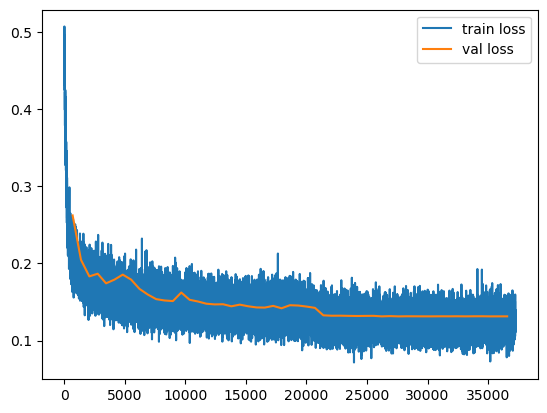

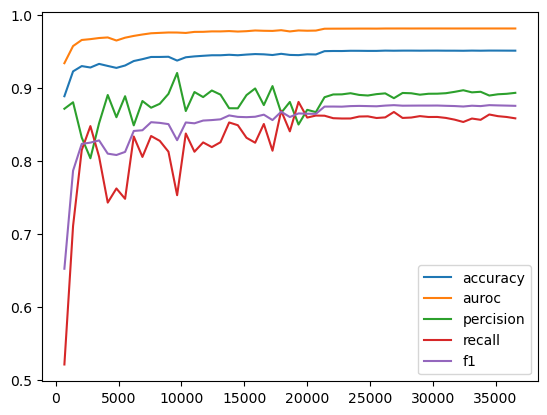

In [64]:
def plot_state():
    print(np.round(running_acc, decimals=4))
    print(np.round(running_auroc, decimals=4))
    plt.plot(np.arange(len(running_loss))[10:], running_loss[10:], label="train loss")
    plt.plot(running_val_loss_idx, running_val_loss, label="val loss")
    plt.legend()
    plt.show()
    plt.plot(running_val_loss_idx, running_acc, label="accuracy")
    plt.plot(running_val_loss_idx, running_auroc, label="auroc")
    plt.plot(running_val_loss_idx, running_percision, label="percision")
    plt.plot(running_val_loss_idx, running_recall, label="recall")
    plt.plot(running_val_loss_idx, running_f1, label="f1")
    plt.legend()
    plt.show()
plot_state()

In [67]:
def val_model_res(model, dataloader):
    model.eval()
    val_loss = 0
    results = []
    targets = []
    with torch.no_grad():
        all_mhc_embs = model.forward_mhc(torch.tensor(np.arange(len(mhc_types))))
        for x_pep, x_tmhc, target in dataloader:
            mhc_embs = all_mhc_embs[x_tmhc]
            res = model(x_pep, mhc_embs)
            results.append(res)
            targets.append(target)
            val_loss += nn.BCELoss(reduction='sum')(res.reshape(-1), target.reshape(-1).float()).item()
    
    res = torch.concat(results).reshape(-1)
    target = torch.concat(targets)
    accuracy = (res.reshape(-1).round() == target.reshape(-1)).float().mean().item()
    val_loss /= len(val_dataloader.dataset)
    return res, target


In [68]:
output, target = val_model_res(model, val_dataloader)

In [72]:
from torchmetrics.classification import BinaryAccuracy
val_df = df.iloc[valid_idx]
data = []
for i, mhc_type in enumerate(mhc_types):
    mask = (df['MHC_type'] == mhc_type)[valid_idx].to_numpy()
    r = output[mask].cpu()
    t = target[mask].cpu()
    res = [
        mhc_type,
        BinaryAccuracy()(r, t).item(),
        binary_precision(r, t).item(),
        binary_recall(r, t).item(),
        binary_f1_score(r, t).item(),
        sum(t).item(),
        sum(mask),
        binary_auroc(r, t).item(),
    ]
    data.append(res)
df_metrics = pd.DataFrame(data, columns=['mhc_type', 'accuracy', 'precision', 'recall', 'f1', 'positive', 'count', 'auroc'])

In [73]:
pd.set_option('display.max_rows', 500)
df_metrics

,mhc_type,accuracy,precision,recall,f1,positive,count,auroc
0,HLA-B*27:05,0.899059,0.841868,0.611944,0.708725,7334,36546,0.911652
1,HLA-B*15:01,0.959762,0.897122,0.902969,0.900036,2762,13768,0.987176
2,HLA-A*31:01,0.935350,0.827550,0.855435,0.841261,920,4594,0.980613
3,HLA-B*18:01,0.971479,0.950820,0.904232,0.926941,449,2244,0.991949
4,HLA-B*57:01,0.956132,0.921100,0.854097,0.886334,2392,11945,0.978195
5,HLA-C*02:02,0.959451,0.894251,0.904465,0.899329,963,4809,0.990359
6,HLA-B*35:01,0.954022,0.890459,0.878559,0.884469,1721,8591,0.980059
7,HLA-A*33:01,0.951807,0.850427,0.921296,0.884444,216,1079,0.981819
8,HLA-B*15:42,0.904594,0.826087,0.666667,0.737864,57,283,0.969725
9,HLA-A*02:06,0.924182,0.815327,0.803218,0.809227,808,4036,0.970192
